In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pykalman import KalmanFilter
%matplotlib inline

Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [27]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
df = pd.read_csv('data/bitcoin_price.csv')
df = df[::-1]
dataset = df.Close.values.reshape(-1,1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# reshape into X=t and Y=t+5
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(None, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=5, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
print(r2_score(trainY, trainPredict[:, 0]))
print(r2_score(testY, testPredict[:, 0]))

Epoch 1/10
 - 6s - loss: 0.0069
Epoch 2/10
 - 5s - loss: 4.8660e-04
Epoch 3/10
 - 5s - loss: 3.4967e-04
Epoch 4/10
 - 5s - loss: 3.2160e-04
Epoch 5/10
 - 5s - loss: 3.1583e-04
Epoch 6/10
 - 5s - loss: 3.1105e-04
Epoch 7/10
 - 5s - loss: 2.8762e-04
Epoch 8/10
 - 5s - loss: 3.0448e-04
Epoch 9/10
 - 5s - loss: 2.9611e-04
Epoch 10/10
 - 5s - loss: 3.0013e-04
0.984577949605
0.758810220514


In [28]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
# trainY[0], trainPredict[:, 0]
observations_train = trainY[0]
measurements_train = trainPredict[:, 0]

observations_test = testY[0]
measurements_test = testPredict[:, 0]

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(observations_train, measurements_train))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(observations_test, measurements_test))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 355.60 RMSE
Test Score: 522.10 RMSE


Score Before Kalman Filtering: 522.10 RMSE and 0.76 R-Square
Score After Kalman Filtering: 523.87 RMSE and 0.76 R-Square


Text(0,0.5,'Price')

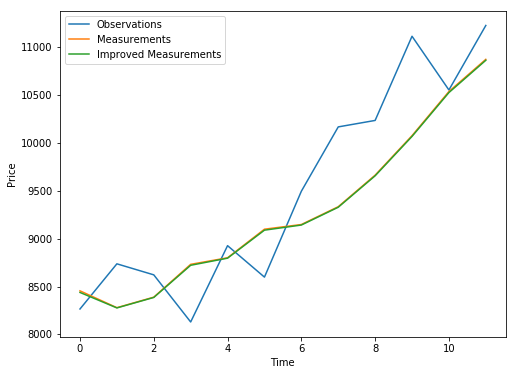

In [29]:
kf = KalmanFilter(initial_state_mean=measurements_test[0])
kf = kf.em(measurements_test, n_iter=50, 
           em_vars='all')
measurements_predicted = (kf.smooth(measurements_test)[0])[:, 0]

trainScore1 = np.sqrt(mean_squared_error(observations_test, measurements_test))
trainScore1_r2 = r2_score(observations_test, measurements_test)
print('Score Before Kalman Filtering: %.2f RMSE and %.2f R-Square' % (trainScore1, trainScore1_r2))

trainScore2 = np.sqrt(mean_squared_error(observations_test, measurements_predicted))
trainScore2_r2 = r2_score(observations_test, measurements_predicted)
print('Score After Kalman Filtering: %.2f RMSE and %.2f R-Square' % (trainScore2, trainScore2_r2))

fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(range(len(observations_test)), observations_test, label="Observations")
ax.plot(range(len(observations_test)), measurements_test, label="Measurements")
ax.plot(range(len(observations_test)), measurements_predicted, label="Improved Measurements")
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Price')